# ABM Model & Analysis

## Imports

In [1]:
import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import SimultaneousActivation, RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from networkx.algorithms.shortest_paths.generic import has_path
import networkx as nx
import random
import pickle
import csv
from tqdm import tqdm, trange
from time import sleep
from collections import Counter
import seaborn as sns

data_path = 'Data/Input/'



In [2]:
#Loading Files
origin = pd.read_csv((data_path + 'origin_ports.csv'))
data = pd.read_csv((data_path + 'clean_distances.csv')) # cleaned to remove routes with same origin & destination (filtered for shortest connection)
distances = data[["prev_port", "next_port", "distance"]] 
distances.astype({'prev_port':'int64', 'next_port':'int64'}).dtypes
origin = origin.astype({'Ref':'int64'})

#Route Blockage Import
route_blockage_dov = pd.read_csv((data_path + 'Route Blockages/' + 'route_blockages_dov.csv'))
route_blockage_gib = pd.read_csv((data_path + 'Route Blockages/'+ 'route_blockages_gib.csv'))
route_blockage_horm = pd.read_csv((data_path + 'Route Blockages/'+ 'route_blockages_horm.csv'))
route_blockage_mal = pd.read_csv((data_path + 'Route Blockages/'+ 'route_blockages_mal.csv'))
route_blockage_pan = pd.read_csv((data_path + 'Route Blockages/'+ 'route_blockages_pan.csv'))
route_blockage_suez = pd.read_csv((data_path + 'Route Blockages/'+ 'route_blockages_suez.csv'))
route_blockage_total = pd.read_csv((data_path + 'Route Blockages/'+ 'route_blockages_total.csv'))
pruning_files = [route_blockage_dov, route_blockage_gib, route_blockage_horm, route_blockage_mal, route_blockage_pan, route_blockage_suez, route_blockage_total]

## Model

In [3]:
"""
Network Model
"""
class ShippingNetwork(Model):
    def __init__(self, distances, major_ports, pruning_files, pruning_schedule, S=100,  s=20, f = 0, x = 3):
        self.major_ports = major_ports
        self.num_ships = S
        self.distances = distances
        self.schedule = SimultaneousActivation(self)
        self.running = True
        self.Ships = []
        self.pruning_files = pruning_files
        self.s = s
        self.f = f
        self.pruning_schedule = pruning_schedule
        self.stp_cnt = 0
        self.x = x 

        #Build Network without closures
        self.G = nx.from_pandas_edgelist(distances, "prev_port", "next_port", ["distance"], create_using=nx.Graph())
        self.G.remove_edges_from(nx.selfloop_edges(self.G))

        #Define Mesa Grid as the just created Network to allow for shipping only in routes
        self.grid = NetworkGrid(self.G) 

        #Build alternate Networks (with closures in place)
        self.G_Dov = self.Cut_Graph(self.G, self.pruning_files[0])
        self.G_Gib = self.Cut_Graph(self.G, self.pruning_files[1])
        self.G_Horm = self.Cut_Graph(self.G, self.pruning_files[2])
        self.G_Mal = self.Cut_Graph(self.G, self.pruning_files[3])
        self.G_Pan = self.Cut_Graph(self.G, self.pruning_files[4])
        self.G_Suez = self.Cut_Graph(self.G, self.pruning_files[5])
        self.G_Total = self.Cut_Graph(self.G, self.pruning_files[6])
  

        #create agents 
        self.Ships = []
       
        for i in tqdm(range(self.num_ships), desc="Placing Ships"):
        
            a = Ship(i+1, self, self.G, self.major_ports,  self.s, self.f, self.x)
            self.schedule.add(a)
            #append to list of ships
            self.Ships.append(a)
        
            #place agent on origin node
            self.grid.place_agent(a, a.start)


        self.datacollector = DataCollector(
            model_reporters={"Graph":"blockage"},
            agent_reporters={"Type": "ship_class",
                            "Foresight": "foresight",
                            "Position": "position", 
                            "Ports of Interest":"report_ports", 
                            "Itinerary":"itinerary", 
                            "Distance_Traveled":"distance_traveled", 
                            "Route":"current_route", 
                            "Route Changes":"route_chng", 
                            "Destination not reachable" : "not_reachable",
                            "Complete": "complete_route",
                            "Success": "sucess", 
                            "Stuck":"stuck"})

    '''
    Function called to cut graphs (done on initialization)
    '''

    def Cut_Graph(self, G, route_blockages):
        return_G = G.copy()  #CRUCIAL TO INCLUDE COPY STATEMENT
        for index in range(len(route_blockages)):
            try:
                return_G.remove_edge(route_blockages.iloc[index]['prev_port'],route_blockages.iloc[index]['next_port'])
            except:
                pass
        return return_G


    '''
    Method allows for change of network (copies specified pre-built )
    '''
        #create ability to remove edges mid-model
    def network_change(self, blockage):
        if blockage == "Dover":
            G_new = self.G_Dov
        elif blockage == "Gibraltar":
            G_new = self.G_Gib
        elif blockage == "Hormuz":
            G_new = self.G_Horm
        elif blockage == "Malacca":
            G_new = self.G_Mal
        elif blockage == "Panama":
            G_new = self.G_Pan
        elif blockage == "Suez":
            G_new = self.G_Suez
        elif blockage == "Total":
            G_new = self.G_Total
        elif blockage == "Open":
            G_new = self.G

        for a in tqdm(self.Ships, desc="Changing Graphs"):
                a.G = G_new


    def step(self):
        if self.stp_cnt == 30:
            self.network_change(self.pruning_schedule)
        elif self.stp_cnt == 60:
            self.network_change("Open")
            #Check if it is time to change the network as per the schedule
        self.schedule.step()    #Run each Agents
        self.datacollector.collect(self)
        self.stp_cnt += 1

In [4]:
"""
Ship Agents
"""
class Ship(Agent):
    def __init__(self, unique_id, model, G, major_ports, s, f, x):
        super().__init__(unique_id, model)
        
        self.major_ports = major_ports
        self.G = G
        self.s = s
        self.f = f
        self.x = x
        self.factor = 1 * self.x


        self.ship_class = np.random.choice(["Large","Normal", "Small"], 1, p=[0.25, 0.5, 0.25])
        self.start_port = self.origin()
        self.destination = self.dest() #sample a destination
        #We sample the origin port from a list of the 50 biggest ports world, with the prob = TAU of the port / TAU of all origin ports for 2017

        self.ports =  [*self.start_port, *self.destination]
        self.report_ports = self.ports.copy()
        
        self.foresight = np.random.poisson(self.f)
        self.state = 0 #0 for active, numbers > 0 for weeks that ships have to "wait" until arrival to port
        self.speed = self.s*24*1.852 
        #speed is given in knots, with 1 knot being 1 nautical mile per hour. Since the model works with distances in km, we convert here (1 nm = 1.852m)

        self.not_reachable = 0 #global counter for Networkx error

        self.origin_failed = 0 #counter for ships not able to reach any of the ports
        self.route_chng = 0
        self.complete_route = 0
        self.steps = 0
        self.sucess = 0
        self.stuck = 0
        self.distance_traveled = 0

        self.init_route, self.init_dist = self.routing() #We keep a copy of the entire itinerary / distance traveled
        self.init_dist = round(self.init_dist,2)
        self.start = self.start_port[0]
        self.current_route, self.current_dist = self.init_route.copy(), self.init_dist  #For comparison & navigational purposes, we use current route & distance
        self.start_speed = self.speed # varying speed
        self.position = self.current_route[0]
        self.next_position = self.current_route[1]
        self.target  = round((self.init_dist // self.start_speed) * self.factor,1) #target to reach all destinations
        self.itinerary = [self.position]
        self.unique_id = unique_id
        self.step_size = self.ident_distance()


    def origin(self):
        """
        Sample origin based on ship type.
        """ 
        p1 = self.major_ports["PROB"].copy()
        p1 /= p1.sum()
        
        if self.ship_class == "Large":
            start_port = np.random.choice(self.major_ports["Ref"],  p=p1)
        elif self.ship_class == "Normal":
            start_port = np.random.choice(self.major_ports["Ref"],  p=p1)

        else:
            r = random.sample(self.G.nodes, k=1)[0] #ships do not originate in isolated nodes
            if not nx.is_isolate(self.G,r):
                start_port = r
            else: #ships never come back to the port of origin
                return self.origin()
            
        return [start_port]



    def dest(self):
        """
        Sample destinations
        """
        p1 = self.major_ports["PROB"][:5].copy()
        p1 /= p1.sum()
        p2 = self.major_ports["PROB"][5:].copy()
        p2 /= p2.sum()
        p3 = self.major_ports["PROB"]
        p3 /= p3.sum()
            
        if self.ship_class == "Large": #large ships only visit large ports

            #we try to mix in top 10 ports with the rest
            k = np.random.randint(1, high = 5)
            end = np.random.choice(self.major_ports["Ref"][:5] , size=1,  p=p1).tolist() + np.random.choice(self.major_ports["Ref"][5:], size=k,  p=p2).tolist()
                        
            
        elif self.ship_class == "Normal":
            k = np.random.randint(1, high = 4)
            end = np.random.choice(self.major_ports["Ref"], replace=False, size=k,  p=p3).tolist()+ [int(i) for i in random.sample(self.G.nodes, k=k)]

        else:
            k = np.random.randint(1, high =6)
            end = [int(i) for i in random.sample(self.G.nodes, k=k)]

        if self.start_port in end:
            return self.dest()

        return end





    def routing(self):
        """
        A greedy version of Travelling Salesman algorithm.
        Takes in a list of ports, with the first port being the origin.
        It loops to find the closest port. Returns a list of ports to visit (an itinerary) and the overall distance.
        """
        ports = self.ports.copy()
        overall_distance = list()
        itinerary = list() 
        itinerary.append([ports[0]])
        not_reached = 0 #local counter for no path between points 
        
        try:
            for j in range(len(ports)):
                distance = dict()
                try:
                    for i in range(1,len(ports)): #look for the closest port
                        distance[ports[i]] = nx.shortest_path_length(self.G, ports[0] , ports[i], weight='distance')
                    next_stop = min(distance, key=distance.get)
                    itinerary.append(nx.shortest_path(self.G, ports[0], next_stop, weight = 'distance')[1:]) #add the route to the closest port to the itinerary
                    overall_distance.append(distance.get(next_stop)) #add distance to the closest port
                    ports.pop(0)
                    ind = ports.index(next_stop)
                    ports.pop(ind)
                    ports.insert(0, next_stop)

                except nx.NetworkXNoPath:
                    self.not_reachable += 1 #global counter for Networx error
                    not_reached += 1 #local counter

        except ValueError: #handle list end
            pass

        if not_reached == len(ports): #if no routes possible routes found, reassign destination
            self.origin_failed += 1
            self.destination = self.dest()
            self.ports =  [*self.start_port, *self.destination]
            if self.origin_failed > 1: #if the problem persists, the ship is stuck
                self.stuck += 1
                self.start_port = self.origin()
                return self.routing() #Recursion go BRRR
            else:
                return self.routing() #recursion brrrrr
        else:
            flat_route = []
            for sublist in itinerary: #flatten the itinerary
                for port in sublist:
                    flat_route.append(port)
            travel_distance = sum(overall_distance)
            return flat_route, travel_distance

    def move(self):

        self.step_size = self.ident_distance() #look up the distance between two cities 
        self.state = self.step_size / self.speed #change state to step amount
        self.current_dist = self.current_dist - self.step_size #adjust current distance minus the distance traveled in the next step
        if nx.has_path(self.G, self.position, self.next_position):
            self.model.grid.move_agent(self, self.next_position) #move the agent
            self.position = self.next_position
            if self.position in self.destination:
                self.destination.pop(self.destination.index(self.position))
            self.current_route.pop(0) #remove the next step from the itinerary
            if len(self.current_route) == 1:
                self.next_position = self.current_route[0] 
            else:
                self.next_position = self.current_route[1] #update current route
        else:
            self.stuck += 1


    def ident_distance(self): #look up the distance of the current step
        try:
            return round(self.G.get_edge_data(self.position, self.next_position, default=0)['distance'],2)
        except:
            return 0
    
    def new_destinations(self): #the ship has completed its full route
        
        self.complete_route += 1
        self.destination = self.dest()
        self.ports =  [self.position, *self.destination]
        self.report_ports = self.ports.copy()
        self.init_route, self.init_dist = self.routing()
        self.init_dist = round(self.init_dist,2)
        self.current_route, self.current_dist = self.init_route.copy(), self.init_dist
        self.target  = (self.init_dist // self.start_speed)  * self.factor
        self.state =  np.random.randint(2,5) #wait at port
 
    def step(self):
        self.state = self.state - 1 #'move' ships by one day progress
        if self.stuck >= 1:
            pass
        else:
            if round(self.state,2) <= 0: #ships that are en-route to the node they are going to next do not move / perform other activities
                self.distance_traveled += self.step_size #ship has arrived at port, let's add the distance traveled to their 
            
                #add the current position to itinerary
                if self.position != self.current_route[-1]: #if current stop is not the final stop
                    self.ports =  [self.position, *self.destination]
                    new_route, new_distance = self.routing() #perform a new routing to compare against current routing
                    new_distance= round(new_distance,2)
                    if (new_route == self.current_route)| (new_distance == self.current_dist): #if current routing is the same as new, just move (default case)
                        self.move()
                        self.itinerary.append(self.position)
                        self.steps += 1 
            
                    # Compare the distances
                    elif new_distance > self.current_dist: #if current route is shorter than newly calculated route, check for obstructions
                        
                        if self.foresight >= (self.current_dist // self.speed): 
                            #check how many steps are you from your final destination. If you are far away, do nothing and remain on course
                            self.current_route = new_route
                            self.current_dist = new_distance
                            self.route_chng += 1
                            self.move()
                            self.itinerary.append(self.position)
                            self.steps +=1

                        else:
                            self.move()
                            self.itinerary.append(self.position)
                            self.steps +=1
                    
                    
                    else: # final option is that current route is longer than new route (think Suez reopening after a while), here, we just take the new option
                        self.current_route = new_route
                        self.current_dist = new_distance
                        self.route_chng += 1
                        self.move()
                        self.itinerary.append(self.position)
                        self.steps +=1
                
                else: #if ship is arrived at final position, get a new route, and start back
                    if self.steps >= self.target: #if the ship manages the reach all the destinations in time, it is "sucessful"
                        self.sucess += 1
                        self.steps = 0
                        self.new_destinations()
                        self.itinerary.append(self.position)
                         #clear the counter
                    else:
                        self.new_destinations()
                        self.itinerary.append(self.position)
                        self.steps = 0 #clear the counter
            else:
                pass

## Model Parameters

Choose the closure to be simulated. Choices are:
- Dover             
- Gibraltar         
- Hormuz            
- Malacca
- Panama
- Suez
- Total (all combined)

In [5]:
pruning_schedule_single = "Gibraltar"


Ships=500                           #number of ships that are simulated 
f_factor=3                          #F factor influences the Foresight ships have which determines how early ships re-route 
x_factor=1.5                        #X factor is the tolerance that we give ships to arrive on time, which influences whether ships will count 
steps = 100

f_factor_batch = range(0, 8, 2)    #for batch runner 


data_path = 'Data/Input/' #set to wherever the data files are, will be used on every input

## Model Instantiation

(Commented out, since run time is ~3hrs. for single run & ~8hrs. for batch run)

In [ ]:
#Single Run
# model = ShippingNetwork(distances, origin, pruning_files, pruning_schedule_single, S=Ships, f=f_factor, x=x_factor)

# for i in trange(steps):
#     model.step()

# agent_state = model.datacollector.get_agent_vars_dataframe()


# #write output of single run to file
# agent_state.to_csv(('Data/Output/'+ pruning_schedule_single + "_" + 'single_run_output.csv'), header = True)


In [ ]:
# # Multiple runs using Batchrunner
# fixed_params = {"distances": distances, "major_ports":origin, "pruning_files": pruning_files, "S": Ships,"pruning_schedule": pruning_schedule_single, "x" : x_factor }
# variable_params = {"f": f_factor_batch}

# batch_run = BatchRunner(ShippingNetwork,
#                         variable_parameters=variable_params,
#                         fixed_parameters=fixed_params,
#                         iterations=3,
#                         max_steps=90,
#                         )
# batch_run.run_all()


# data_collector_agents = batch_run.get_collector_agents()
# keys = data_collector_agents.keys()



# # write output of batch runner to pickle file
# with open((data_path + 'batch_out.pickle'), 'wb') as handle:
#     pickle.dump(data_collector_agents, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # write output data to separate csv files
# for i in range(len(keys)):
#     df = batch_out[keys[i]]
#     name = ('Data/Output/Batch Out/' + 'Batch_out_f-' + str(keys[i][0]) + '_iteration-' + str(keys[i][1]) + '.csv')
#     df.to_csv(name,index=True, header=True)

# Single Run Analysis

In [6]:
data_path_output = 'Data/Output/'

In [7]:
ports_df = pd.read_csv(data_path + 'ports.csv')
ports_df["coords"] = ports_df["coords"].apply(lambda x: eval(x)[0])
ports_df["x"] = ports_df["coords"].apply(lambda x: x[0])
ports_df["y"] = ports_df["coords"].apply(lambda x: x[1])

In [8]:
single_run_none = pd.read_csv(data_path_output + 'open_single_run_out.csv')
single_run_suez = pd.read_csv(data_path_output + 'Suez_single_run_output.csv')
single_run_hormuz = pd.read_csv(data_path_output + 'Hormuz_single_run_output.csv')
single_run_malacca = pd.read_csv(data_path_output + 'Malacca_single_run_output.csv')
single_run_panama = pd.read_csv(data_path_output + 'Panama_single_run_output.csv')
single_run_gibraltar = pd.read_csv(data_path_output + 'Gibraltar_single_run_output.csv')
single_run_dover = pd.read_csv(data_path_output + 'Dover_single_run_output.csv')
single_run_all = pd.read_csv(data_path_output + 'Total_single_run_output.csv')

last_step = single_run_suez["Step"].max()

In [4]:
# ''' Groupby Step'''
step_none = single_run_none.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
step_suez = single_run_suez.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
step_hormuz = single_run_hormuz.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
step_malacca = single_run_malacca.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
step_panama = single_run_panama.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
step_dover = single_run_dover.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
step_gibraltar = single_run_gibraltar.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
step_all = single_run_all.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]

# ''' Groupby Type'''
type_none = single_run_none[single_run_none["Step"]==last_step].groupby("Type")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck", "Distance_Traveled"]
type_suez = single_run_suez[single_run_suez["Step"]==last_step].groupby("Type")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck", "Distance_Traveled"]
type_hormuz = single_run_hormuz[single_run_hormuz["Step"]==last_step].groupby("Type")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck", "Distance_Traveled"]
type_malacca = single_run_malacca[single_run_malacca["Step"]==last_step].groupby("Type")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck", "Distance_Traveled"] 
type_panama = single_run_panama[single_run_panama["Step"]==last_step].groupby("Type")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck", "Distance_Traveled"]
type_dover = single_run_dover[single_run_dover["Step"]==last_step].groupby("Type")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck", "Distance_Traveled"]
type_gibraltar = single_run_gibraltar[single_run_gibraltar["Step"]==last_step].groupby("Type")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck", "Distance_Traveled"]
type_all = single_run_all[single_run_all["Step"]==last_step].groupby("Type")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck", "Distance_Traveled"]

<ipython-input-4-795286ef6fba>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  step_none = single_run_none.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
<ipython-input-4-795286ef6fba>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  step_suez = single_run_suez.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
<ipython-input-4-795286ef6fba>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  step_hormuz = single_run_hormuz.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
<ipython-input-4-795286ef6fba>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a li

## Top Ports

In [5]:
'''Top ports'''
single_runs = [single_run_none, single_run_suez, single_run_hormuz, single_run_malacca, single_run_panama, single_run_gibraltar, single_run_dover, single_run_all]

def top_ports(single_runs,k):
    '''
    Find top k most visited ports
    '''
    positions = []
    for run in single_runs:
        positions += run["Position"].values.tolist()

    c = Counter(positions)
    top10 = c.most_common(k)

    for i in range(k):
        ref = top10[i][0]
        name = ports_df[ports_df["Unnamed: 0"]==ref]["PORT_NAME"].values.tolist()[0]
        coords = ports_df[ports_df["Unnamed: 0"]==ref]["coords"].values.tolist()[0]
        top10[i] = list(top10[i])
        top10[i].pop(0)
        top10[i].insert(0,name)
        top10[i].insert(3,coords)

    return top10


In [6]:
'''Top ports'''
top_20 = pd.DataFrame(top_ports(single_runs,20), columns = ["Name", "Freq", "coords"])
top_20

Name   Freq                                     coords
0                     NaN  20314   (102.37028212945444, 1.8290091666666664)
1                     NaN  13654   (102.42442633128908, 1.8047319109027944)
2                     NaN   7680   (103.15488846149456, 1.4831491666666667)
3                     NaN   7648   (104.46545358457107, 1.6849391666666667)
4                     NaN   7497     (24.63976747009027, 37.96943267086536)
5                     NaN   7270   (120.61321662839978, 35.970416666666665)
6                  DURBAN   6601  (31.083391138778502, -29.858009526506066)
7            Richards Bay   6521  (32.119184313341975, -28.806122923269868)
8             Izmir Liman   6449         (26.547129509932702, 38.675322602)
9             Çesme Liman   6385        (26.328729844124943, 38.7419989655)
10  daishangaoting island   6329             (122.2723572362936, 30.263755)
11                    NaN   6223     (104.60349288548039, 1.44117249419086)
12          Izmir Harbour   6189             (26.56758063625, 38.752503418)
13       Gökçeada Harbour   5612         (25.887499982, 39.962074616500004)
14          Tekirdag Port   5386   (27.208352877600802, 40.602882932499995)
15              HONG KONG   5297   (114.11976109159025, 22.354190000000003)
16      Çanakkale Harbour   4992    (26.13409775161738, 39.996088212000004)
17              HANSWEERT   4486              (3.787823282608696, 51.33401)
18            KISARAZU KO   4037     (139.8108422040744, 35.37190006580204)
19          Shanghai Gang   3979   (122.04640073442107, 31.216186503499998)

## Global statistics

In [7]:
step_none = step_none.sum().diff(periods=1)
step_all = step_all.sum().diff(periods=1)
step_dover = step_dover.sum().diff(periods=1)
step_gibraltar = step_gibraltar.sum().diff(periods=1)
step_hormuz = step_hormuz.sum().diff(periods=1)
step_malacca = step_malacca.sum().diff(periods=1)
step_suez = step_suez.sum().diff(periods=1)
step_panama = step_panama.sum().diff(periods=1)

In [8]:
steps = [step_none,  step_all, step_dover, step_gibraltar, step_hormuz, step_malacca, step_suez, step_panama]
labels = ['None', 'Total', 'Dover', 'Gibraltar', 'Hormuz', 'Malacca', 'Suez', 'Panama']

columns = ['Route Changes',	'Destination not reachable',	'Complete',	'Success',	'Stuck']
t = np.arange(last_step)

labels_type = [ 'Dover', 'Gibraltar', 'Hormuz', 'Malacca', 'None', 'Panama', 'Suez',  'Total']
types = [type_dover.sum(), type_gibraltar.sum(), type_hormuz.sum(), type_malacca.sum(), type_none.sum(), type_panama.sum(),  type_suez.sum(), type_all.sum()]
single_runs = [single_run_none, single_run_all, single_run_dover, single_run_gibraltar, single_run_hormuz, single_run_malacca, single_run_suez, single_run_panama]

In [9]:
last = [run[run["Step"]==last_step][:] for run in single_runs]
last_steps = pd.concat(last,axis=0, keys=labels)
last_steps.head()

Step  AgentID        Type  Foresight  Position  \
None 44500    90        1   ['Large']          4      6869   
     44501    90        2  ['Normal']          2      3918   
     44502    90        3   ['Large']          2      6865   
     44503    90        4  ['Normal']          5      1342   
     44504    90        5   ['Small']          4      6859   

                                      Ports of Interest  \
None 44500               [2232, 2232, 2088, 1997, 2489]   
     44501             [3679, 1975, 47914, 4120, 18020]   
     44502               [4057, 2005, 4030, 2189, 1997]   
     44503  [2071, 3128, 47914, 2189, 2783, 4046, 3232]   
     44504        [3815, 6773, 24038, 2961, 3877, 3081]   

                                                    Itinerary  \
None 44500  [2034, 2040, 2041, 17887, 29561, 2135, 29561, ...   
     44501  [17295, 4381, 7068, 7072, 7073, 1943, 5982, 19...   
     44502  [3128, 6861, 6865, 6859, 6869, 3365, 2088, 336...   
     44503  [2001, 6919, 23786, 2132, 3128, 6861, 6865, 68...   
     44504  [6928, 6994, 15616, 6748, 17918, 6999, 2063, 2...   

            Distance_Traveled  \
None 44500            8724.18   
     44501            7207.44   
     44502            2102.62   
     44503            3544.35   
     44504           10760.23   

                                                        Route  Route Changes  \
None 44500  [25354, 25355, 1975, 6864, 6865, 6859, 6869, 2...              0   
     44501                                       [2614, 4120]              0   
     44502  [2111, 1592, 1333, 1762, 7026, 1342, 1594, 842...              0   
     44503  [6861, 3128, 6861, 6865, 6859, 6869, 6868, 621...              0   
     44504                                             [6773]              0   

            Destination not reachable  Complete  Success  Stuck  
None 44500                          0         2        2      0  
     44501                          0         1        1      0  
     44502                          0         1        1      0  
     44503                          0         1        1      0  
     44504                          0         1        1      0

Text(0.5, 1.0, 'Distance travelled under different blockages (total)')

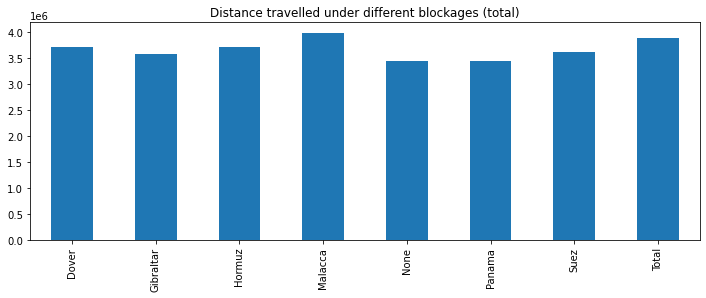

In [10]:
total_distances = last_steps.groupby(level = 0)["Distance_Traveled"].sum()
total_distances.plot(kind = "bar", figsize = (12,4))
plt.title("Distance travelled under different blockages (total)")



Text(0.5, 1.0, "Distance travelled under different blockages (centered on 'Open')")

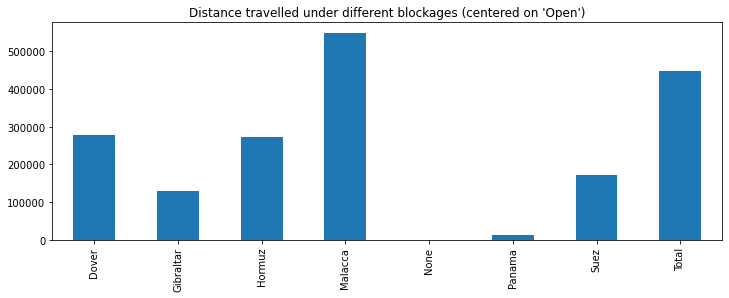

In [11]:
centered = (total_distances - total_distances["None"])
centered.plot(kind = "bar", figsize = (12,4))
plt.title("Distance travelled under different blockages (centered on 'Open')")


Text(0.5, 1.0, "Distance travelled under different blockages (centered on 'Open')")

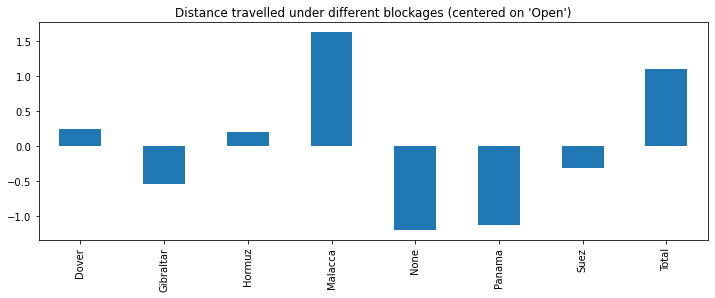

In [12]:
re_centered = (centered - centered.mean() )/ centered.std()
re_centered.plot(kind = "bar", figsize = (12,4))
plt.title("Distance travelled under different blockages (centered on 'Open')")

Dover         7
Gibraltar     8
Hormuz        0
Malacca       6
None          0
Panama       13
Suez          3
Total        31
Name: Stuck, dtype: int64


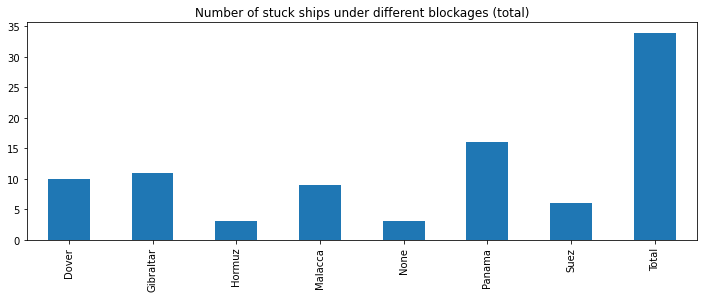

In [13]:
total_stucks = last_steps.groupby(level = 0)["Stuck"].sum()
total_stucks.plot(kind = "bar", figsize = (12,4))
plt.title("Number of stuck ships under different blockages (total)")
print((total_stucks - total_stucks["None"]))

Dover         341
Gibraltar     409
Hormuz        -78
Malacca      1476
None            0
Panama        -36
Suez         -105
Total        1842
Name: Route Changes, dtype: int64


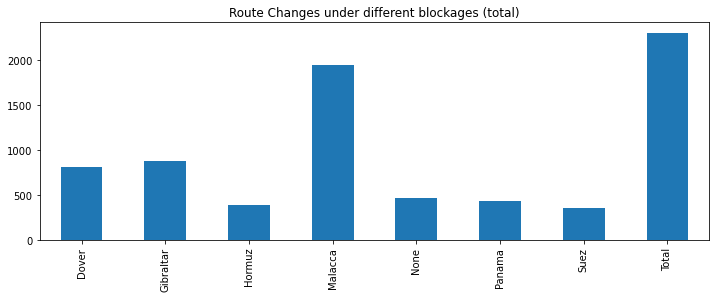

In [14]:
total_route_cng = last_steps.groupby(level = 0)["Route Changes"].sum()
total_route_cng.plot(kind = "bar", figsize = (12,4))
plt.title("Route Changes under different blockages (total)")
print((total_route_cng - total_route_cng["None"]))

Dover         96
Gibraltar     51
Hormuz        78
Malacca      162
None           0
Panama       223
Suez          13
Total        302
Name: Destination not reachable, dtype: int64


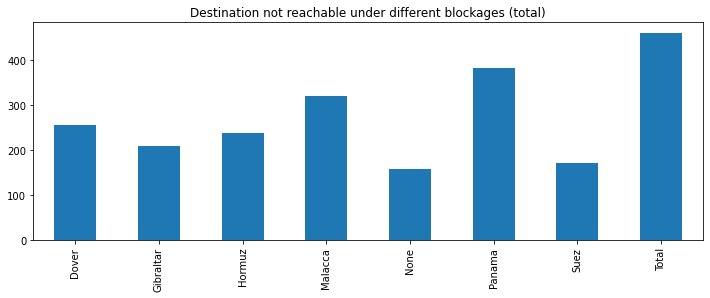

In [15]:
total_dest_not_reached = last_steps.groupby(level = 0)["Destination not reachable"].sum()
total_dest_not_reached.plot(kind = "bar", figsize = (12,4))
plt.title("Destination not reachable under different blockages (total)")
print((total_dest_not_reached - total_dest_not_reached["None"]))

Dover       -14
Gibraltar   -57
Hormuz      -52
Malacca     -62
None          0
Panama      -41
Suez        -53
Total       -70
Name: Complete, dtype: int64


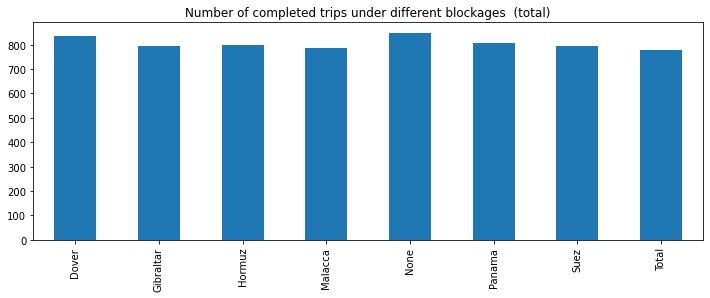

In [16]:
total_complete = last_steps.groupby(level = 0)["Complete"].sum()
total_complete.plot(kind = "bar", figsize = (12,4))
plt.title("Number of completed trips under different blockages  (total)")
print((total_complete - total_complete["None"]))

## Step analysis

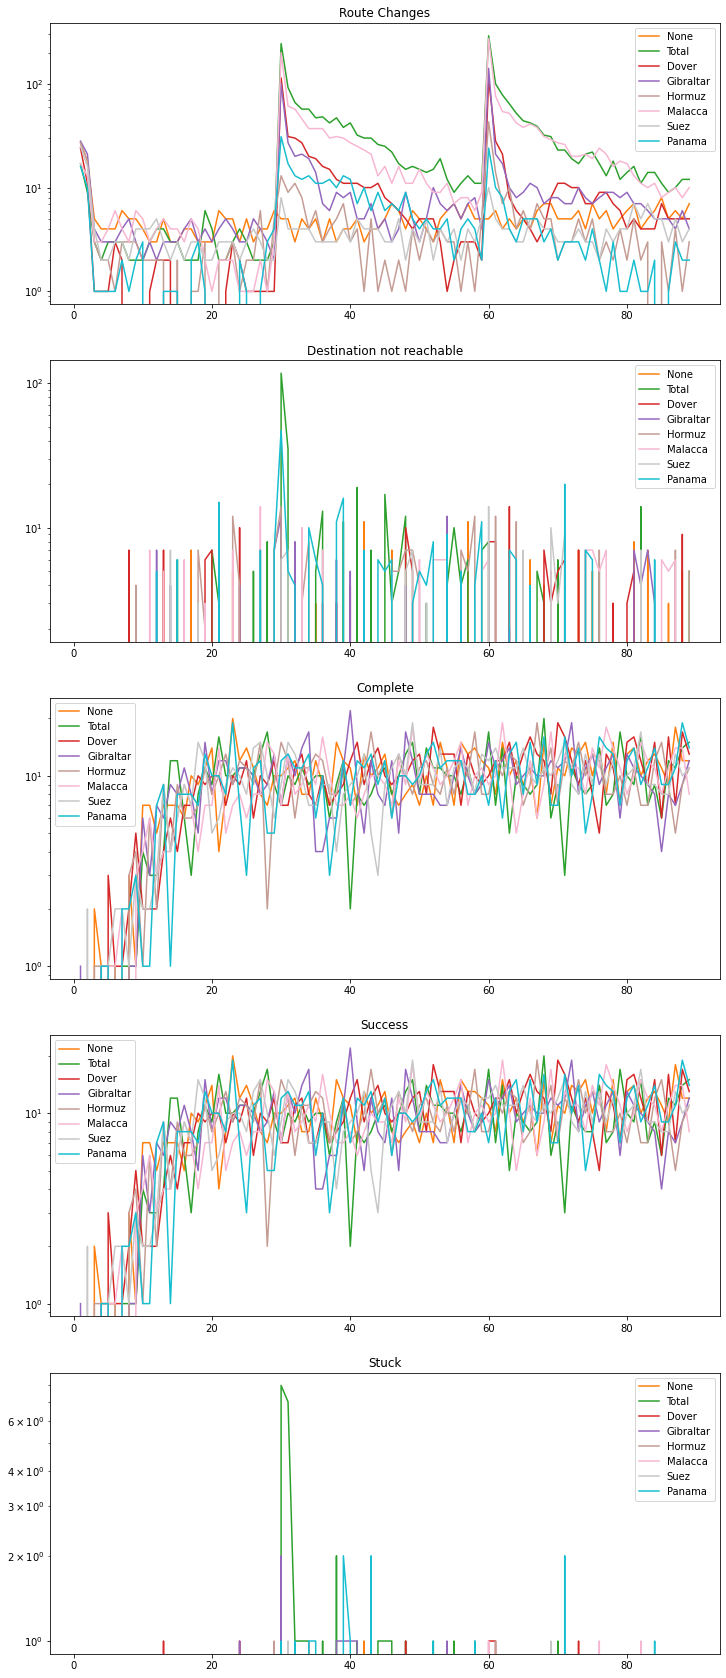

In [17]:
'''
Plots WITH LOGS
'''

k = len(columns)
fig, ax = plt.subplots(k, facecolor='w', figsize=(12,30), squeeze=False)

color = plt.cm.tab20(np.linspace(0.1,0.9,len(steps)))
ax = ax.T.flatten()

for i in range(k):
    for j,c in zip(range(len(steps)),color):
        ax[i].plot(t, steps[j][:len(t)][[columns[i]]], c=c, label = labels[j])    
        ax[i].legend(fancybox = True)
    ax[i].set_title(columns[i])
    ax[i].set_yscale('log')
    



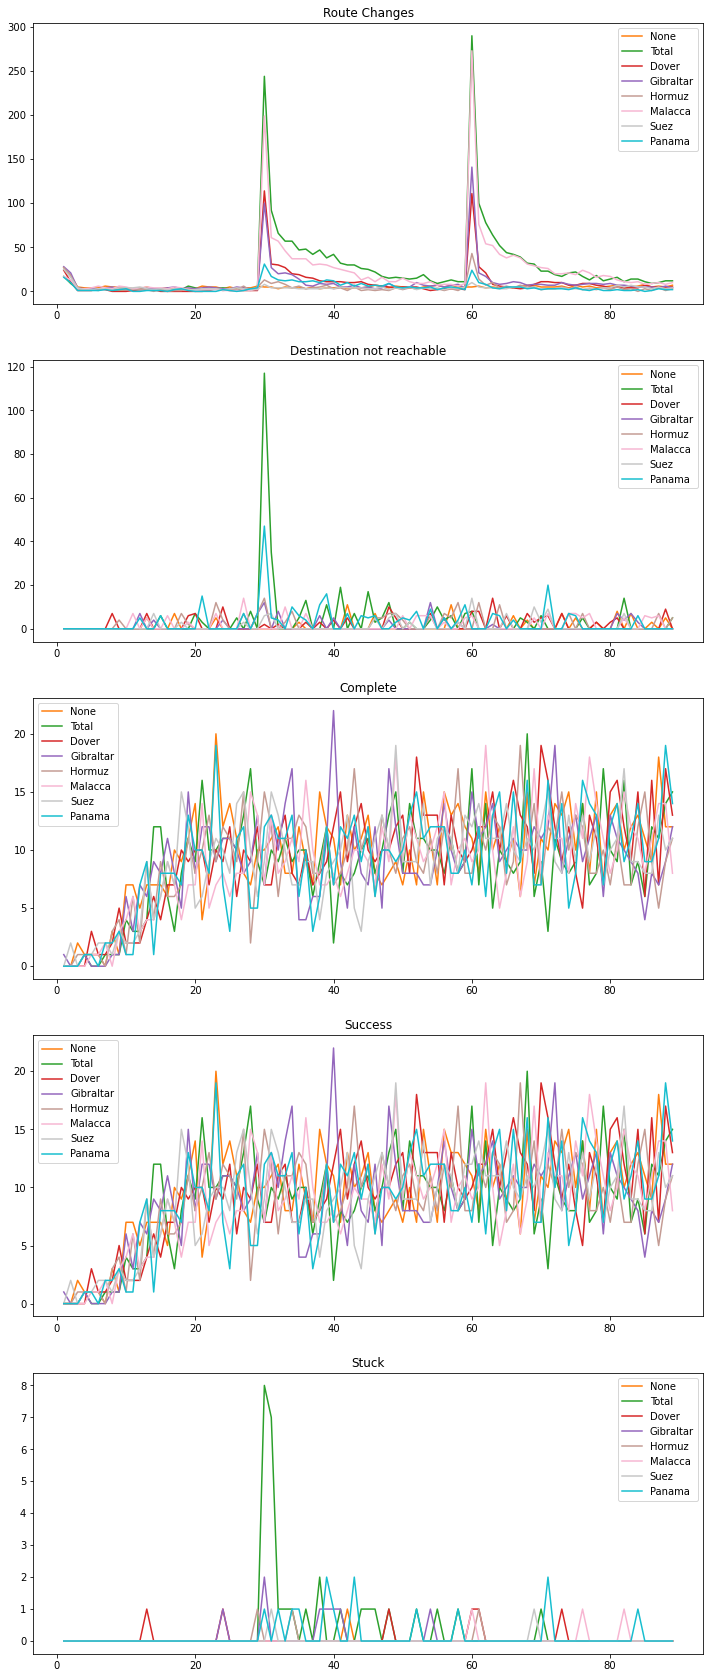

In [18]:
'''
Plots WITHOUT LOG
'''
k = len(columns)
fig, ax = plt.subplots(k, facecolor='w', figsize=(12,30), squeeze=False)

color = plt.cm.tab20(np.linspace(0.1,0.9,len(steps)))
ax = ax.T.flatten()

for i in range(k):
    for j,c in zip(range(len(steps)),color):
        ax[i].plot(t, steps[j][:len(t)][[columns[i]]], c=c, label = labels[j])    
        ax[i].legend(fancybox = True)
    ax[i].set_title(columns[i])
    #ax[i].set_yscale('log')
    



# Type Analysis

In [19]:
labels_type_norm = [ 'Dover', 'Gibraltar', 'Hormuz', 'Malacca','Panama', 'Suez',  'Total']
types_norm = [type_dover.sum()-type_none.sum(), type_gibraltar.sum()-type_none.sum(), type_hormuz.sum()-type_none.sum(), type_malacca.sum()-type_none.sum(),  type_panama.sum()-type_none.sum(),  type_suez.sum()-type_none.sum(), type_all.sum()-type_none.sum()]
types_df = pd.concat(types_norm,axis=1, keys=labels_type_norm).T

In [20]:
types_df.columns = ['Large', 'Normal', 'Small']

(array([0, 1, 2]),
 [Text(0, 0, 'Large'), Text(1, 0, 'Normal'), Text(2, 0, 'Small')])

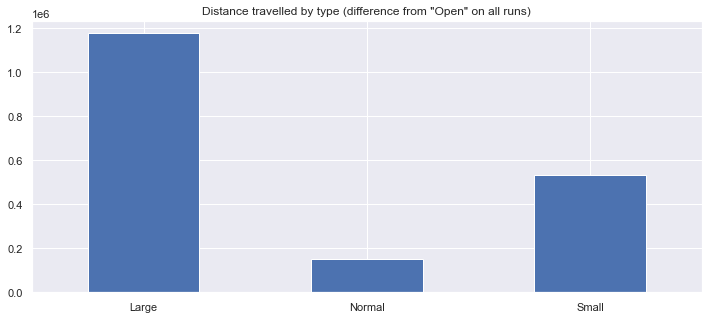

In [21]:
sns.set_theme(color_codes=True)
types_df.groupby(level = 1).sum().loc['Distance_Traveled'].plot(kind = "bar", figsize = (12,5), title = 'Distance travelled by type (difference from "Open" on all runs)')
plt.xticks(rotation = 0)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Complete'),
  Text(1, 0, 'Route Changes'),
  Text(2, 0, 'Destination not reachable'),
  Text(3, 0, 'Success'),
  Text(4, 0, 'Stuck')])

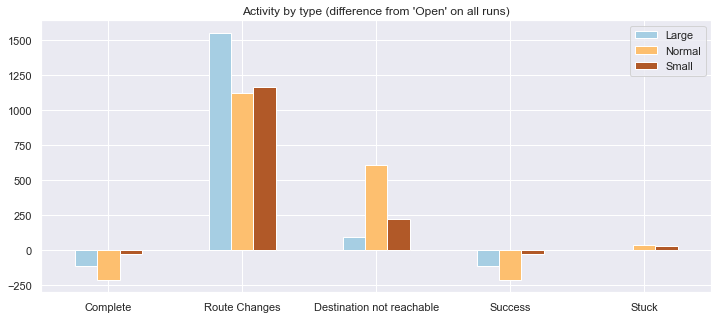

In [22]:
types_df.groupby(level = 1).sum().loc[['Complete', 'Route Changes', 'Destination not reachable', 'Success', 'Stuck']].plot(kind = "bar", figsize = (12,5),  colormap = 'Paired')
plt.title("Activity by type (difference from 'Open' on all runs)")
plt.xticks(rotation = 0)

(array([0, 1]), [Text(0, 0, 'Complete'), Text(1, 0, 'Route Changes')])

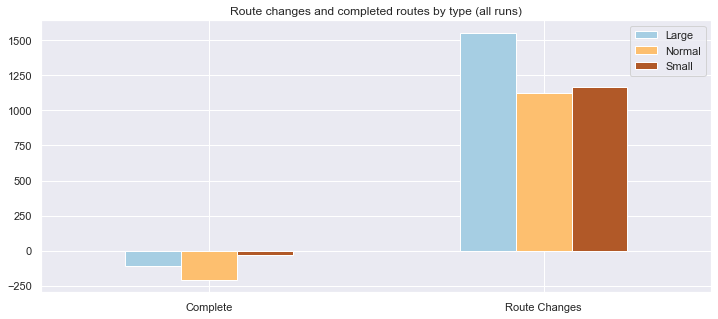

In [23]:
types_df.groupby(level = 1).sum().loc[['Complete', 'Route Changes']].plot(kind = "bar", figsize = (12,5),  colormap = 'Paired')
plt.title("Route changes and completed routes by type (all runs)")
plt.xticks(rotation = 0)

(array([0]), [Text(0, 0, 'Destination not reachable')])

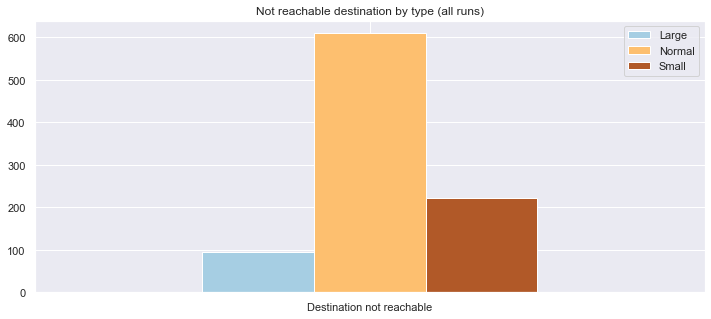

In [24]:
types_df.groupby(level = 1).sum().loc[['Destination not reachable']].plot(kind = "bar", figsize = (12,5), colormap = 'Paired')
plt.title("Not reachable destination by type (all runs)")
plt.xticks(rotation = 0)

In [25]:
success=pd.DataFrame()
changes=pd.DataFrame()
destination=pd.DataFrame()
complete=pd.DataFrame()
stuck=pd.DataFrame()

for i in range(len(types)):
    changes = changes.append(types[i].T.loc[[columns[0]]])
    destination = destination.append(types[i].T.loc[[columns[1]]])
    complete = complete.append(types[i].T.loc[[columns[2]]])
    success = success.append(types[i].T.loc[[columns[3]]])
    stuck = stuck.append(types[i].T.loc[[columns[4]]])

changes['simulation'] = labels_type
destination['simulation'] = labels_type
complete['simulation'] = labels_type
success['simulation'] = labels_type
stuck['simulation'] = labels_type

success.columns = ['Large', 'Normal', 'Small', 'simulation']
changes.columns = ['Large', 'Normal', 'Small', 'simulation']
complete.columns = ['Large', 'Normal', 'Small', 'simulation']
destination.columns = ['Large', 'Normal', 'Small', 'simulation']
stuck.columns = ['Large', 'Normal', 'Small', 'simulation']

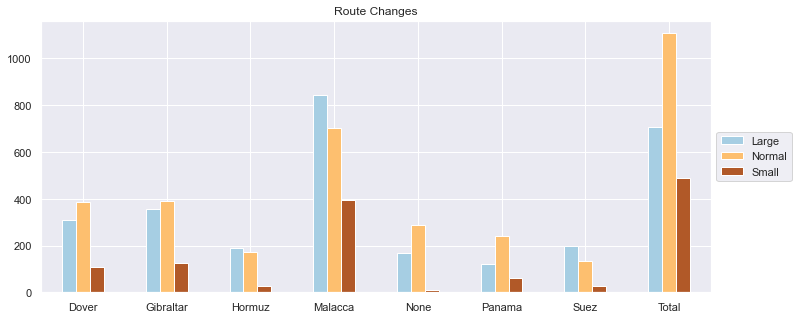

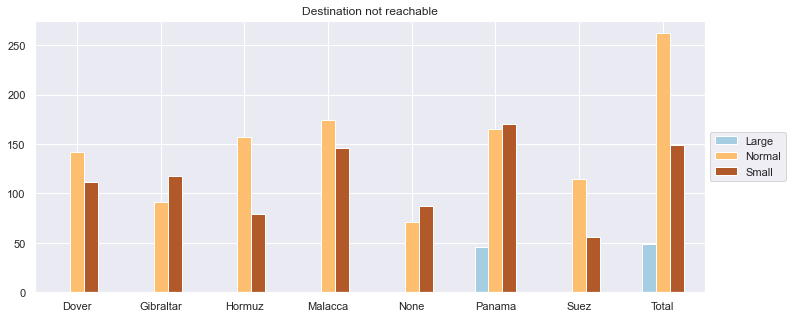

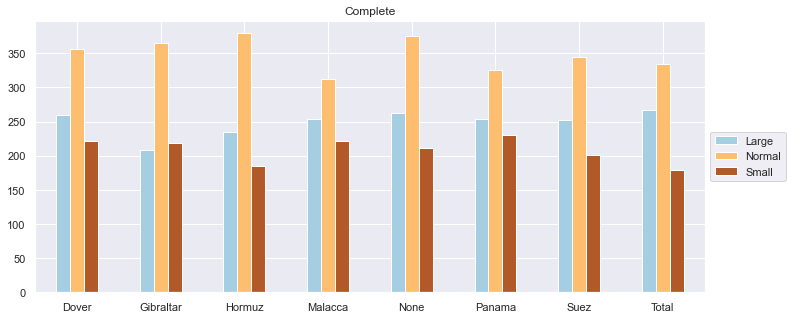

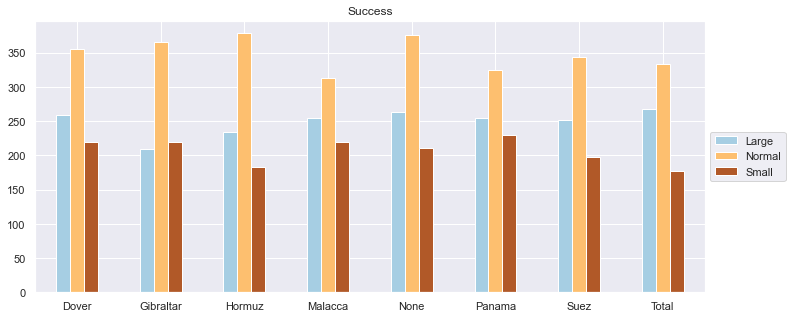

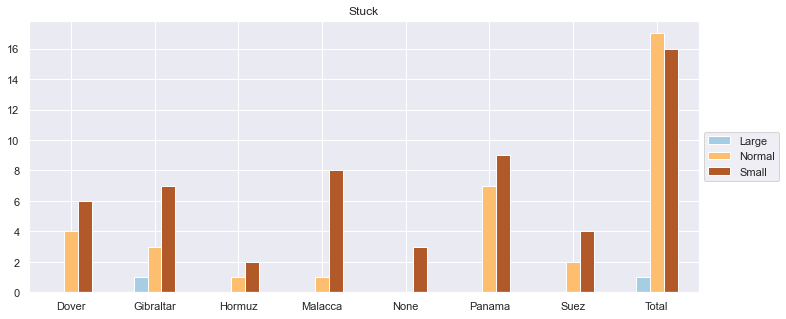

In [26]:
import seaborn as sns
sns.set_theme(color_codes=True)
sns.set_context('notebook')

dfs = [changes, destination, complete, success, stuck]
for i, df in enumerate(dfs):
   ax = df.plot(x='simulation', y = ['Large', 'Normal', 'Small'], kind='bar', title = columns[i], figsize = (12, 5), colormap = 'Paired', rot = 0)
   ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
   ax.xaxis.set_label_text("")

Text(0.5, 0, '')

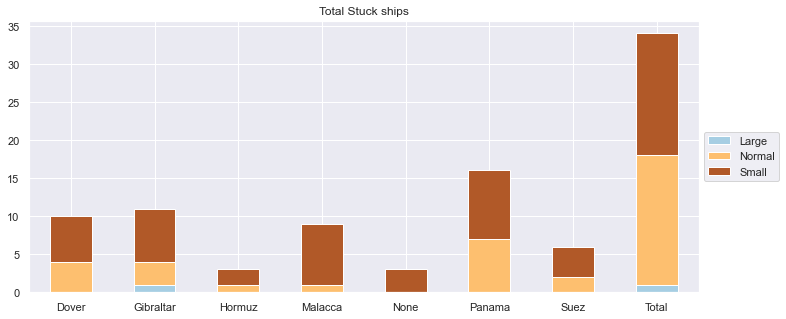

In [27]:
ax = stuck.plot(x='simulation', y = ['Large', 'Normal', 'Small'], kind='bar', title = 'Total Stuck ships', figsize = (12, 5), colormap = 'Paired', stacked = True, rot=0)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.xaxis.set_label_text('')

Text(0.5, 0, '')

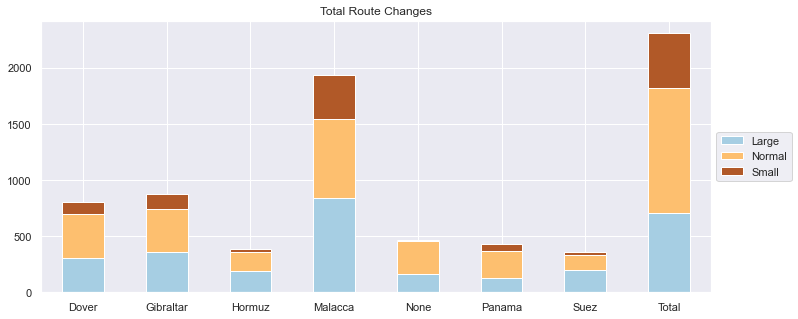

In [28]:
ax = changes.plot(x='simulation', y = ['Large', 'Normal', 'Small'], kind='bar', title = 'Total Route Changes', figsize = (12, 5), colormap = 'Paired', stacked = True, rot=0)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.xaxis.set_label_text("")

Text(0.5, 0, '')

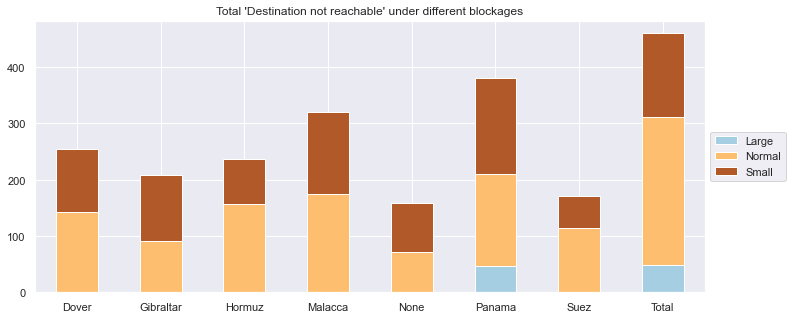

In [29]:
ax = destination.plot(x='simulation', y = ['Large', 'Normal', 'Small'], kind='bar', title = "Total 'Destination not reachable' under different blockages", figsize = (12, 5), colormap = 'Paired', stacked = True, rot=0)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.xaxis.set_label_text("")

In [30]:
complete['Total Complete'] = complete['Large'] + complete['Normal'] + complete['Small']

Text(0.5, 0, '')

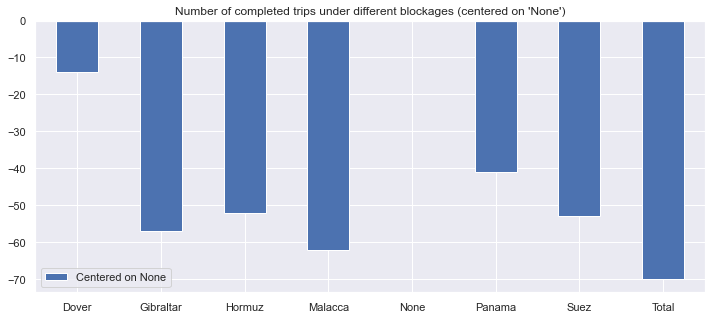

In [31]:
complete['Centered on None'] = complete['Total Complete'] - complete[complete.simulation == 'None']['Total Complete']
ax = complete.plot(x='simulation', y = ['Centered on None'], kind='bar', title = "Number of completed trips under different blockages (centered on 'None')", figsize = (12, 5),  rot=0, sort_columns = True)
ax.xaxis.set_label_text("")

<AxesSubplot:title={'center':'Ratio of successful to complete trips'}>

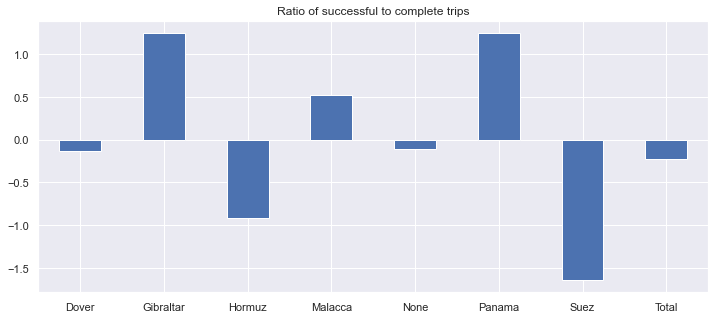

In [32]:
complete_to_succcess = (last_steps.groupby(level = 0)["Success"].sum() / last_steps.groupby(level = 0)["Complete"].sum())
complete_to_succcess_norm = ((complete_to_succcess - complete_to_succcess.mean() ) / complete_to_succcess.std())
complete_to_succcess_norm.plot(kind = "bar", figsize = (12,5), title = 'Ratio of successful to complete trips', rot=0)

## Distance Analysis

In [33]:
distance = pd.DataFrame()
for i in range(len(types)):
    distance = distance.append(types[i].T.loc['Distance_Traveled'])
distance['simulation'] = labels_type
distance.columns = ['Large', 'Normal', 'Small', 'simulation']

In [34]:
distance['total_distance'] = distance['Large']+distance['Normal']+ distance['Small']

Text(0.5, 0, '')

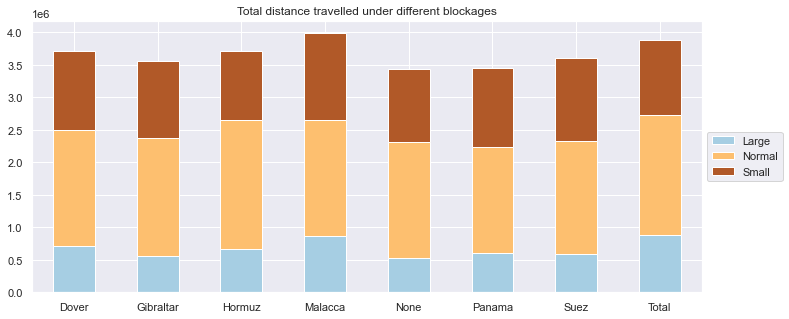

In [35]:
ax = distance.plot(x='simulation', y = ['Large', 'Normal', 'Small'], kind='bar', title = 'Total distance travelled under different blockages', figsize = (12, 5), colormap = 'Paired', stacked = True, rot = 0)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.xaxis.set_label_text("")

Text(0.5, 0, '')

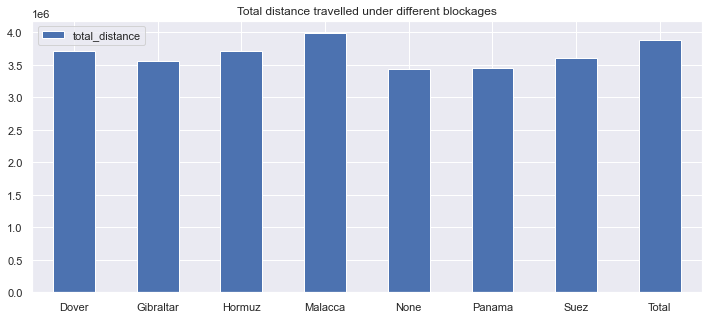

In [36]:
ax = distance.plot(x='simulation', y = 'total_distance', kind='bar', title = 'Total distance travelled under different blockages' , figsize = (12, 5), stacked = True, rot = 0)
ax.xaxis.set_label_text("")

Text(0.5, 0, '')

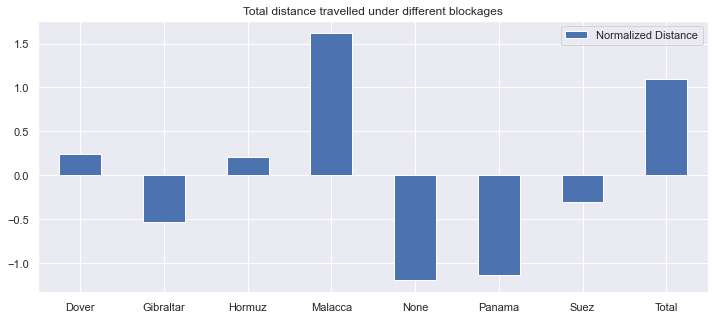

In [37]:
distance['Normalized Distance'] = (distance['total_distance'] - distance['total_distance'].mean()) / distance['total_distance'].std()
ax = distance.plot(x='simulation', y = 'Normalized Distance', kind='bar', title = 'Total distance travelled under different blockages' , figsize = (12, 5), rot = 0)
ax.xaxis.set_label_text("")

Text(0.5, 0, '')

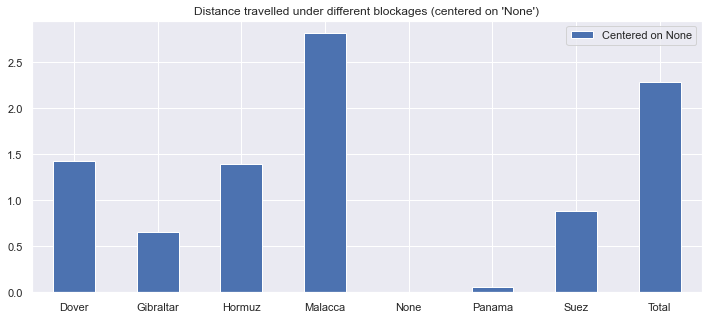

In [38]:


distance['Total Distance'] = distance['Large'] + distance['Normal'] + distance['Small']
distance['Centered on None'] = (distance['Total Distance'] - distance[distance.simulation == 'None']['Total Distance']) / distance['Total Distance'].std()
ax = distance.plot(x='simulation', y = ['Centered on None'], kind='bar', title = "Distance travelled under different blockages (centered on 'None')", figsize = (12, 5),  rot=0)
ax.xaxis.set_label_text("")

# Batch Runner Analysis

In [9]:
with open((data_path_output + 'Batch Out/' +'batch_out.pickle'), 'rb') as handle:
    batch_out = pickle.load(handle)

keys = list(batch_out.keys())

In [ ]:
# # write output data to separate csv files
# for i in range(len(keys)):
#     df = batch_out[keys[i]]
#     name = ('Data/Output/Batch Out/' + 'Batch_out_f-' + str(keys[i][0]) + '_iteration-' + str(keys[i][1]) + '.csv')
#     df.to_csv(name,index=True, header=True)

In [10]:
batch_0_0 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-0_iteration-0.csv')
batch_0_1 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-0_iteration-1.csv')
batch_0_2 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-0_iteration-2.csv')
batch_2_3 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-2_iteration-3.csv')
batch_2_4 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-2_iteration-4.csv')
batch_2_5 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-2_iteration-5.csv')
batch_4_6 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-4_iteration-6.csv')
batch_4_7 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-4_iteration-7.csv')
batch_4_8 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-4_iteration-8.csv')
batch_6_9 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-6_iteration-9.csv')
batch_6_10 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-6_iteration-10.csv')
batch_6_11 = pd.read_csv(data_path_output + 'Batch Out/' +'Batch_out_f-6_iteration-11.csv')

last_step = batch_6_11["Step"].max()

In [4]:
# ''' Groupby Step'''
batch_0_0_ = batch_0_0.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
batch_0_1_ = batch_0_1.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
batch_0_2_ = batch_0_2.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
batch_2_3_ = batch_2_3.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
batch_2_4_ = batch_2_4.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
batch_2_5_ = batch_2_5.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
batch_4_6_ = batch_4_6.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
batch_4_7_ = batch_4_7.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
batch_4_8_ = batch_4_8.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
batch_6_9_ = batch_6_9.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
batch_6_10_ = batch_6_10.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
batch_6_11_ = batch_6_11.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]

<ipython-input-4-e5b1c8a9783d>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  batch_0_0_ = batch_0_0.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
<ipython-input-4-e5b1c8a9783d>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  batch_0_1_ = batch_0_1.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
<ipython-input-4-e5b1c8a9783d>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  batch_0_2_ = batch_0_2.groupby("Step")["Route Changes", "Destination not reachable", "Complete", "Success", "Stuck"]
<ipython-input-4-e5b1c8a9783d>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  batch

In [5]:
# ''' Groupby Type'''
batch00 = batch_0_0[batch_0_0["Step"]==last_step]
batch01 = batch_0_1[batch_0_1["Step"]==last_step]
batch02 = batch_0_2[batch_0_2["Step"]==last_step]
batch23 = batch_2_3[batch_2_3["Step"]==last_step]
batch24 = batch_2_4[batch_2_4["Step"]==last_step]
batch25 = batch_2_5[batch_2_5["Step"]==last_step]
batch46 = batch_4_6[batch_4_6["Step"]==last_step]
batch47 = batch_4_7[batch_4_7["Step"]==last_step]
batch48 = batch_4_8[batch_4_8["Step"]==last_step]
batch69 = batch_6_9[batch_6_9["Step"]==last_step]
batch610 = batch_6_10[batch_6_10["Step"]==last_step]
batch611 = batch_6_11[batch_6_11["Step"]==last_step]

In [6]:
frames = [batch00,batch01,batch02,batch23,batch24,batch25,batch46,batch47,batch48,batch69,batch610,batch611]
result = pd.concat(frames)

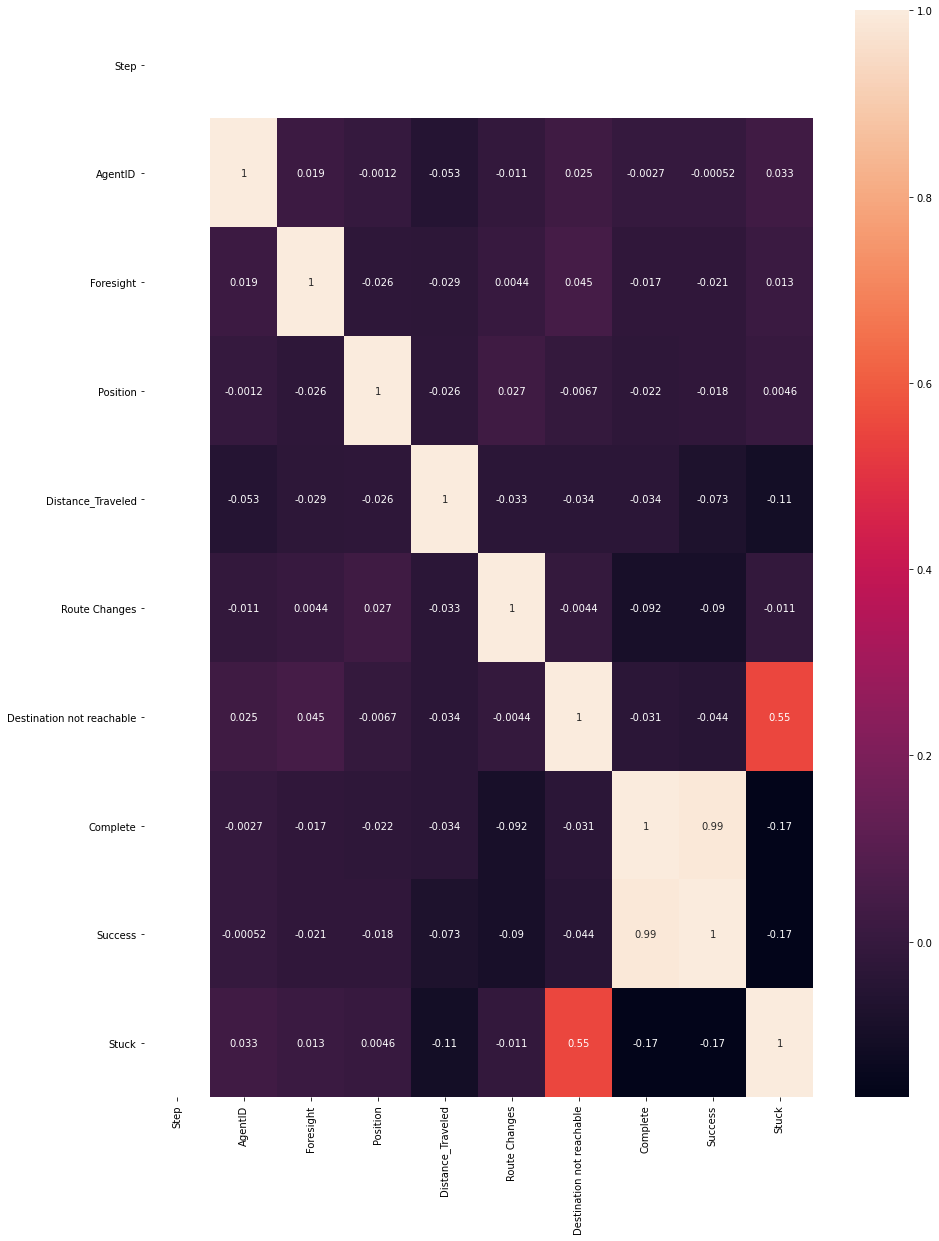

In [9]:
plt.subplots(figsize=(15,20))
sns.heatmap(result.corr(), annot=True)
plt.show()

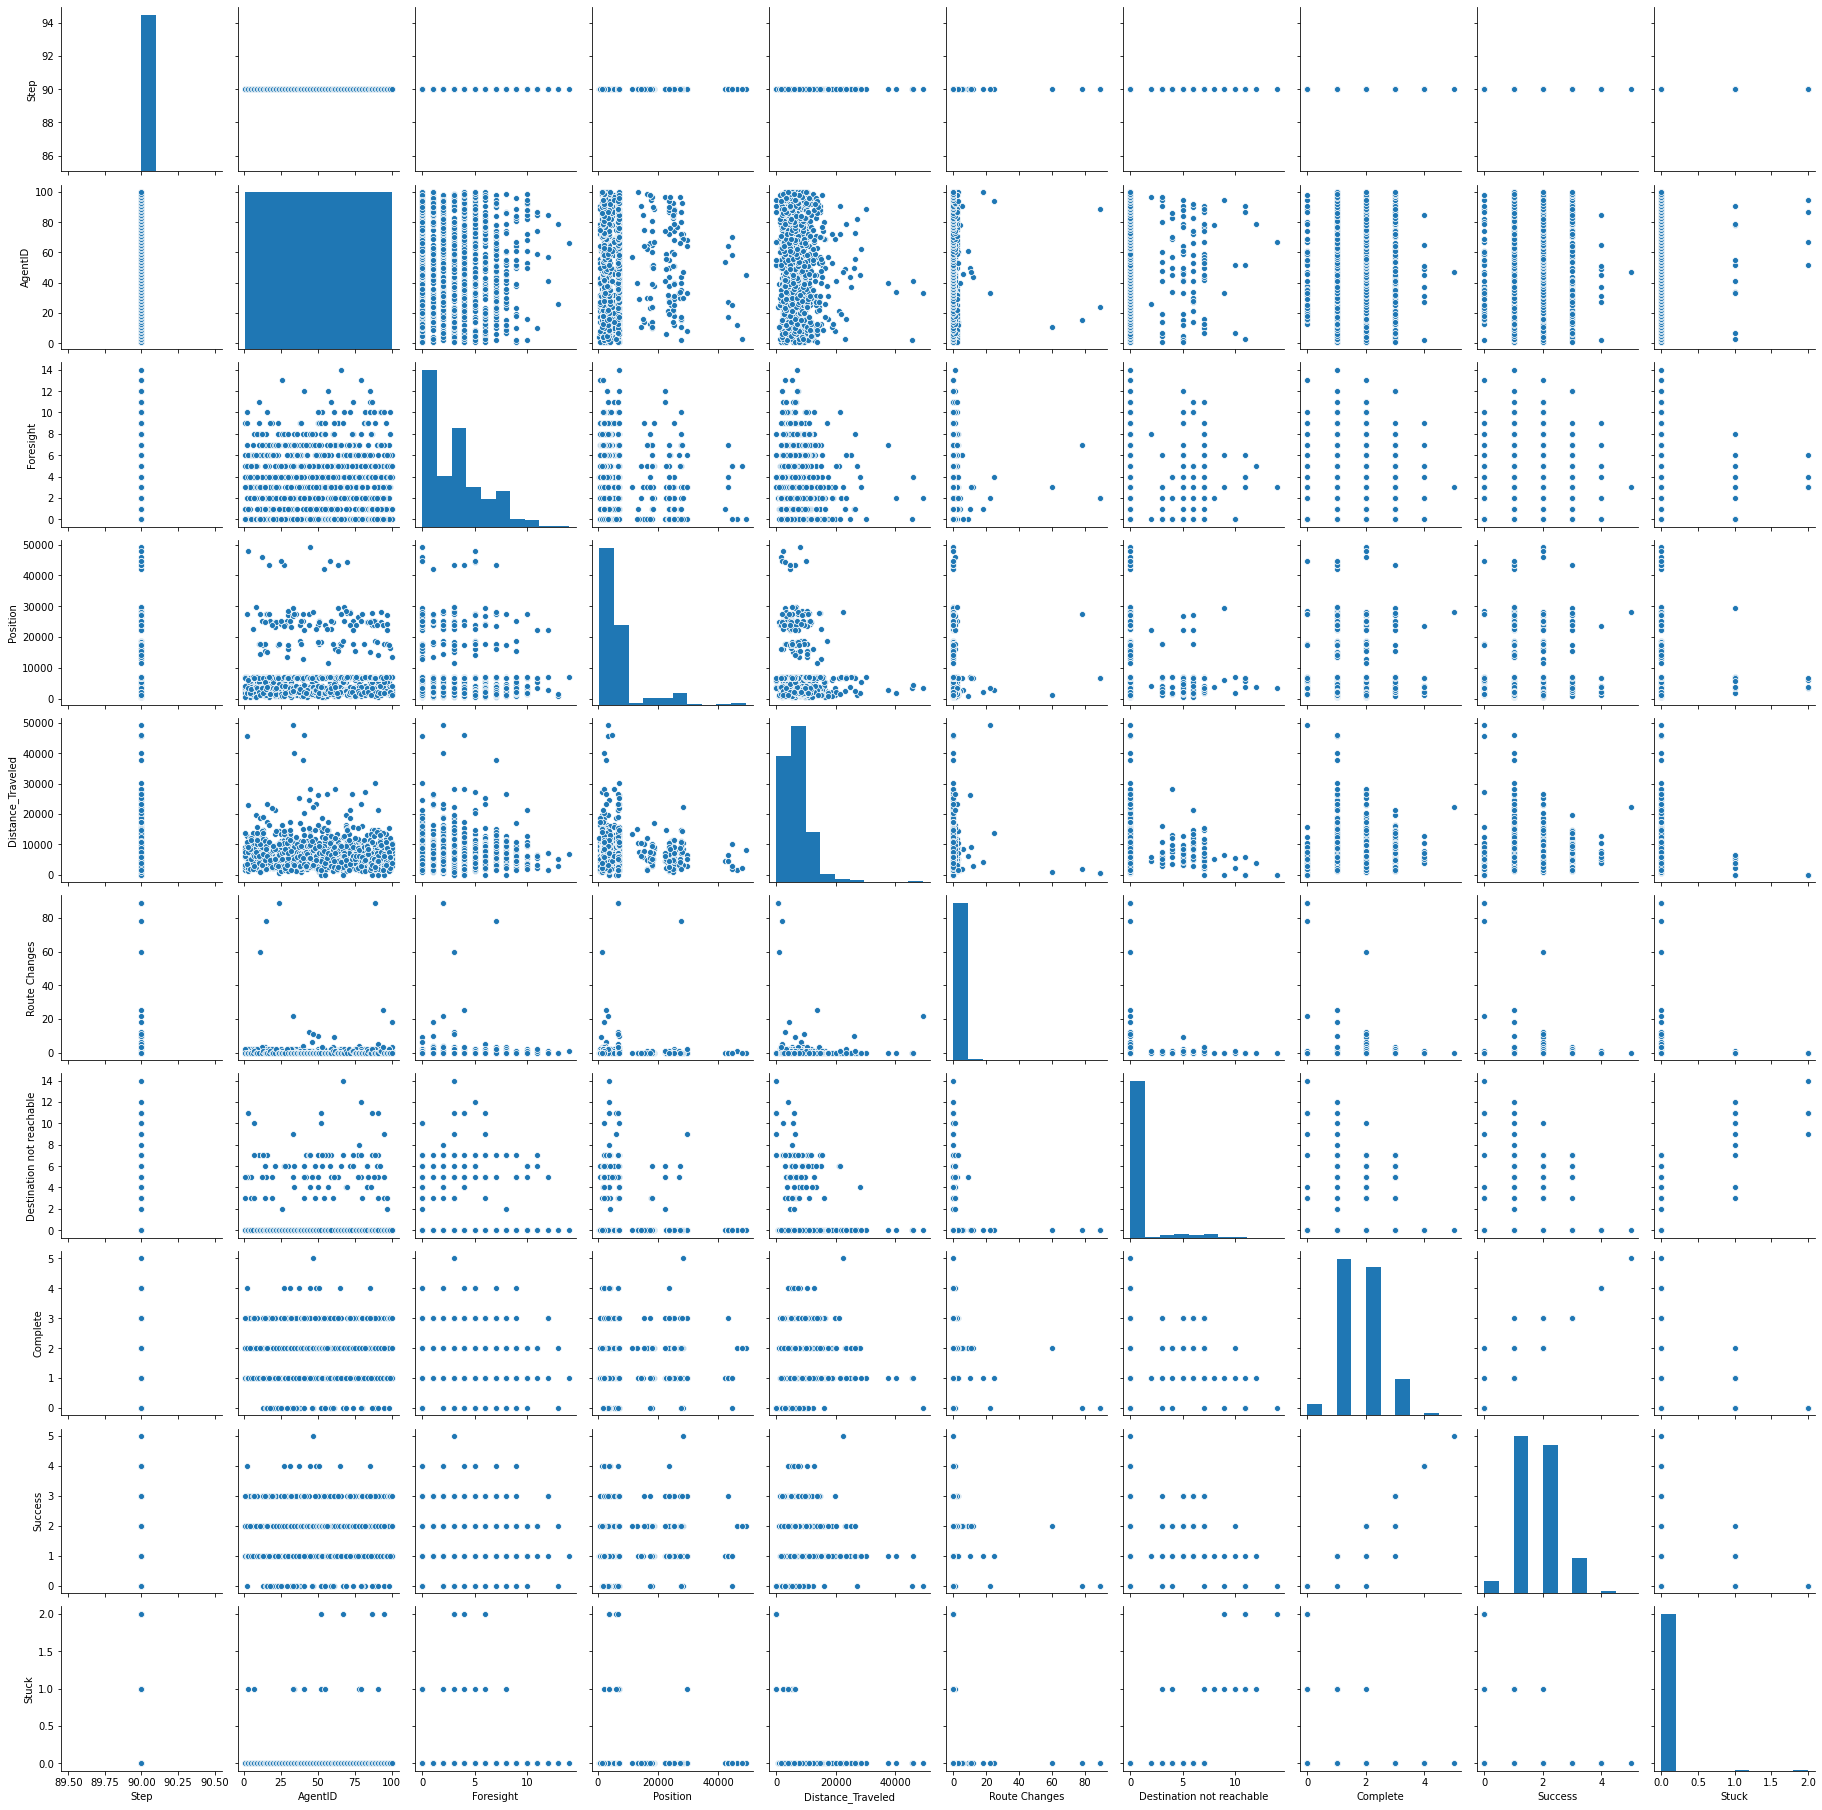

In [10]:
sns.pairplot(result, kind="scatter")
plt.show()

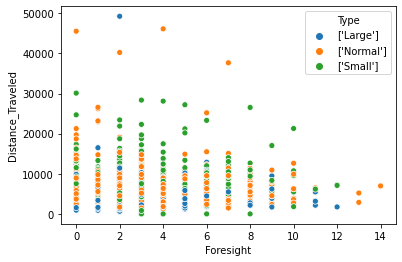

In [11]:
sns.scatterplot(x=result.Foresight, y=result.Distance_Traveled, hue="Type", data=result)

# given a foresight, small ships travel longer distances wrt large and normal ones

In [12]:
from scipy.stats import linregress
linregress(result['Foresight'], result['Distance_Traveled'])

LinregressResult(slope=-50.34089073731636, intercept=7159.70462238019, rvalue=-0.02896072914278204, pvalue=0.31615343370028787, stderr=50.19966186697832)

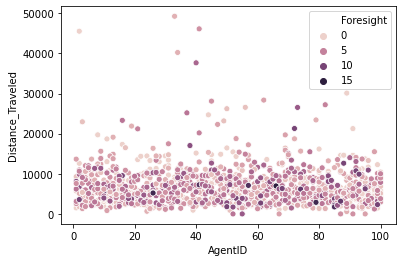

In [13]:
sns.scatterplot(x=result.AgentID, y=result.Distance_Traveled, hue="Foresight", data=result)

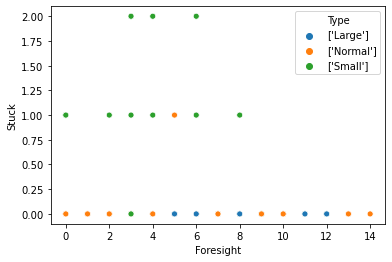

In [14]:
sns.scatterplot(x=result.Foresight, y=result.Stuck,hue="Type", data=result);

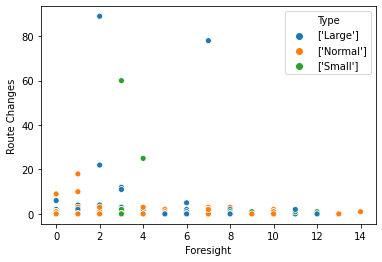

In [15]:
sns.scatterplot(x=result.Foresight, y=result["Route Changes"], hue="Type", data=result);

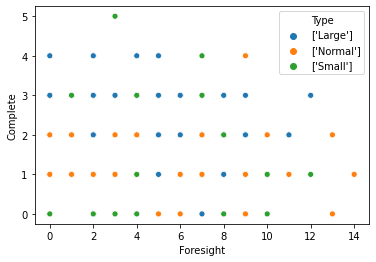

In [16]:
sns.scatterplot(x=result.Foresight, y=result.Complete, hue="Type", data=result);

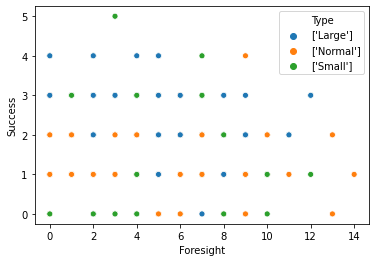

In [17]:
sns.scatterplot(x=result.Foresight, y=result.Success, hue="Type", data=result);

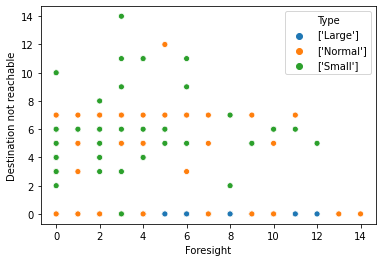

In [18]:
sns.scatterplot(x=result.Foresight, y=result["Destination not reachable"], hue="Type", data=result);